In [ ]:
import numpy as np

from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST

import torch.nn.functional as F

np.random.seed(0)
torch.manual_seed(0)

In [ ]:

def patchify(images, patch_size):

  b_size, img_c, img_w, img_h = images.shape

  assert img_w == img_h, "This implementation only considers images with equal widths and heights"
  assert img_w % patch_size == 0, "Image size is not a multiple of patch size"

  n_patches_dim = int(img_w / patch_size)
  n_patches = pow(n_patches_dim, 2)

  patches = torch.zeros(b_size, n_patches, patch_size*patch_size)

  for i, image in enumerate(images):
    p = 0
    for h in range(n_patches_dim):
      for w in range(n_patches_dim):
        patches[i, p, :] = image[:, h*patch_size:(h+1)*patch_size, w*patch_size:(w+1)*patch_size].flatten()
        p+=1

  return patches

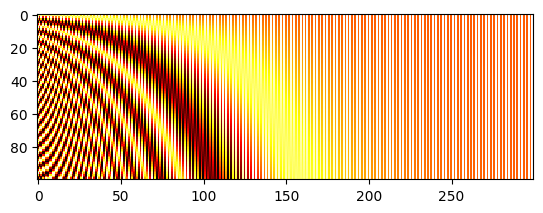

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def get_positional_embeddings(sequence_length, d):
    pe = torch.ones(sequence_length, d)
    position = torch.arange(0, sequence_length).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d, 2) *
                          -(math.log(10000.0) / d))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    #pe = pe.unsqueeze(0)

    #for i in range(sequence_length):
        #for j in range(d):
            #result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return pe

if __name__ == "__main__":


  plt.imshow(get_positional_embeddings(100, 300), cmap="hot", interpolation="nearest")
  plt.show()

In [ ]:
import copy

def clones(module, N):
  "Generates N identical layers"
  return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


In [ ]:
import math

def attention(q, k, v, dim):

  scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(dim)
  attn = F.softmax(scores, dim=-1)
  out = torch.matmul(attn, v)

  return out

In [ ]:
class MultiHeadAttention(nn.Module):

  def __init__(self, h, d_model):

    # Super constructor
    super(MultiHeadAttention, self).__init__()

    self.h = h
    self.d_k = d_model // h

    self.linears = clones(nn.Linear(d_model, d_model), 4)


  def forward(self, im):
    nbatches = im.size(0)

    # Linear projections to all batches
    q, k, v = [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
              for l, x in zip(self.linears, (im, im, im))]

    # Apply attention to projected batches
    z = attention(q, k, v, self.d_k)

    # Concatenate all
    z = self.linears[-1](z.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k))

    return z

In [ ]:
class EncoderBlock(nn.Module):

  def __init__(self, n_head, h_dim):

    # Super constructor
    super(EncoderBlock, self).__init__()

    self.h_dim = h_dim
    self.n_head = n_head

    self.ln = nn.LayerNorm(self.h_dim)
    self.mhsa = MultiHeadAttention(self.n_head, self.h_dim)

    self.mlp = nn.Sequential(nn.Linear(h_dim, h_dim*4),
                              nn.GELU(),
                              nn.Linear(h_dim*4, h_dim))

  def forward(self, x):

    out = x + self.mhsa(self.ln(x))

    out = out + self.mlp(self.ln(out))

    return out

In [ ]:
class ViT(nn.Module):

  def __init__(self, n_classes=10, patch_size=4, hidden_dim=8, n_heads=2, n_blocks=2, chw=(1, 28, 28)):

    # Super constructor
    super(ViT, self).__init__()


    self.chw = chw # (C, H, W)
    self.patch_size = patch_size # patch height/width
    self.hidden_dim = hidden_dim
    self.n_classes = n_classes
    self.n_heads = n_heads
    self.n_blocks = n_blocks

    # Linear embedding
    self.input_dim = int(chw[0] * pow(self.patch_size, 2))
    self.linear_emb = nn.Linear(self.input_dim, self.hidden_dim)

    # Learnable classification token
    self.class_token = nn.Parameter(torch.randn(1, self.hidden_dim))

    # Positional embedding
    self.register_buffer('positional_embeddings',get_positional_embeddings(
        pow(int(self.chw[1] / self.patch_size), 2) + 1, self.hidden_dim), persistent=False)

    # Transformer encoder
    self.EncoderBlocks = nn.ModuleList([EncoderBlock(self.n_heads, self.hidden_dim) for _ in range(self.n_blocks)])

    # Classification
    self.classif = nn.Sequential(nn.Linear(self.hidden_dim, n_classes),
                                 nn.Softmax(dim=-1))


  def forward(self, images):

    n, c, h, w = images.shape

    # Patchify
    patches = patchify(images, self.patch_size).to(self.positional_embeddings.device)

    # Linear embedding
    tokens = self.linear_emb(patches)

    # Add classification token
    tokens = torch.stack([torch.vstack((self.class_token, tokens[i])) for i in range(len(tokens))])

    # Add positional embedding
    out = tokens + self.positional_embeddings.repeat(n, 1, 1)

    # Transformer encoding
    for block in self.EncoderBlocks:
      out = block(out)

    # Classification
    out = out[:, 0]

    return self.classif(out)

In [ ]:
def main():
    # Loading data
    transform = ToTensor()

    train_set = MNIST(root='.', train=True, download=True, transform=transform)
    test_set = MNIST(root='.', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_set, shuffle=True, batch_size=128)
    test_loader = DataLoader(test_set, shuffle=False, batch_size=128)

    # Defining model and training options
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

    model = ViT(n_classes=10, patch_size=4, hidden_dim=8, n_heads=2, n_blocks=2, chw=(1, 28, 28)).to(device)

    N_EPOCHS = 15
    LR = 0.005

    # Training loop
    optimizer = Adam(model.parameters(), lr=LR)
    criterion = CrossEntropyLoss()
    for epoch in trange(N_EPOCHS, desc="Training"):
        train_loss = 0.0
        for batch in train_loader:#tqdm(train_loader, desc=f"Epoch {epoch + 1} in training", leave=False):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)

            train_loss += loss.detach().cpu().item() / len(train_loader)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")

    # Test loop
    with torch.no_grad():
        correct, total = 0, 0
        test_loss = 0.0
        for batch in tqdm(test_loader, desc="Testing"):
            x, y = batch
            x, y = x.to(device), y.to(device)
            y_hat = model(x)
            loss = criterion(y_hat, y)
            test_loss += loss.detach().cpu().item() / len(test_loader)

            correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
            total += len(x)
        print(f"Test loss: {test_loss:.2f}")
        print(f"Test accuracy: {correct / total * 100:.2f}%")

In [ ]:
main()

Using device:  cuda (Tesla T4)


Training:   7%|▋         | 1/15 [02:32<35:35, 152.57s/it]

Epoch 1/15 loss: 2.14


Training:  13%|█▎        | 2/15 [05:01<32:36, 150.54s/it]

Epoch 2/15 loss: 1.98


Training:  20%|██        | 3/15 [07:30<29:57, 149.79s/it]

Epoch 3/15 loss: 1.86


Training:  27%|██▋       | 4/15 [09:58<27:20, 149.16s/it]

Epoch 4/15 loss: 1.80


Training:  33%|███▎      | 5/15 [12:26<24:46, 148.62s/it]

Epoch 5/15 loss: 1.76


Training:  40%|████      | 6/15 [14:54<22:15, 148.35s/it]

Epoch 6/15 loss: 1.73


Training:  47%|████▋     | 7/15 [17:22<19:46, 148.33s/it]

Epoch 7/15 loss: 1.72


Training:  53%|█████▎    | 8/15 [19:52<17:21, 148.77s/it]

Epoch 8/15 loss: 1.66


Training:  60%|██████    | 9/15 [22:21<14:52, 148.79s/it]

Epoch 9/15 loss: 1.64


Training:  67%|██████▋   | 10/15 [24:50<12:24, 148.92s/it]

Epoch 10/15 loss: 1.63


Training:  73%|███████▎  | 11/15 [27:19<09:56, 149.03s/it]

Epoch 11/15 loss: 1.62


Training:  80%|████████  | 12/15 [29:55<07:33, 151.18s/it]

Epoch 12/15 loss: 1.62


Training:  87%|████████▋ | 13/15 [32:32<05:05, 152.85s/it]

Epoch 13/15 loss: 1.61


Training:  93%|█████████▎| 14/15 [35:08<02:33, 153.69s/it]

Epoch 14/15 loss: 1.61


Training: 100%|██████████| 15/15 [37:41<00:00, 150.77s/it]


Epoch 15/15 loss: 1.61


Testing: 100%|██████████| 79/79 [00:24<00:00,  3.24it/s]

Test loss: 1.61
Test accuracy: 84.85%
